# Gaissbergferner - simple mass-balance and volume change estimates!

This notebook shows in a simplified way how the mass-balance was estimated by the OGGM model and what this means for the future. 
As our model is normally only used for many glaciers, it is not specialised to represent robustly the mass-balance for a single glacier. So, the results here should be interpreted with caution and it is just one of many possible solutions.  

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np

import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline

In [2]:
cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-ref-mb', reset=False)
cfg.PARAMS['border'] = 80

2022-03-21 12:01:19: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-03-21 12:01:19: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-03-21 12:01:19: oggm.cfg: Multiprocessing: using all available processors (N=8)
2022-03-21 12:01:19: oggm.cfg: PARAMS['border'] changed from `40` to `80`.


Let's get our Gaissbergferner (each glacier has an id, for Gaissbergferner it is : 'RGI60-11.00836')

In [3]:
gdir = workflow.init_glacier_directories(['RGI60-11.00836'], from_prepro_level=3)[0]
tasks.init_present_time_glacier(gdir)

2022-03-21 12:01:20: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2022-03-21 12:01:20: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


### This is how the glacier domain looks like in the model:

Text(0.5, 1.0, 'gaissbergferner')

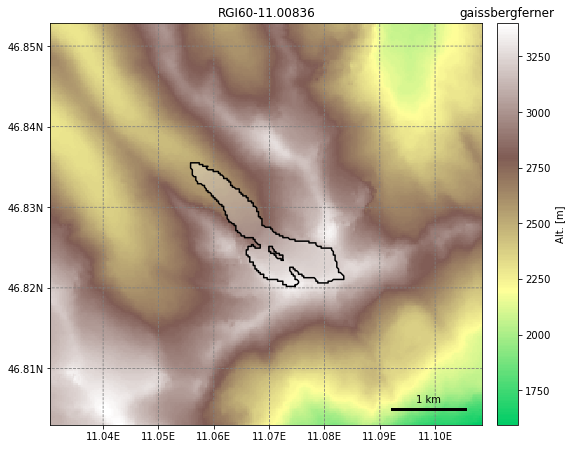

In [4]:
from oggm import graphics
graphics.plot_domain(gdir, figsize=(8, 7))
plt.title('gaissbergferner')

And below is how it computes later on the mass-balance, it estimates one flowline with widths and altitude

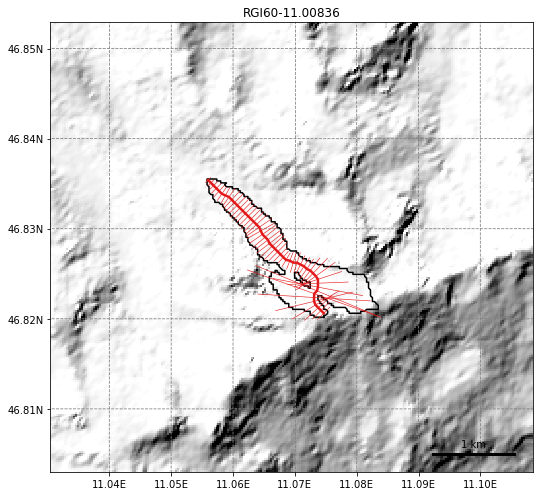

In [5]:
graphics.plot_catchment_width(gdir, corrected=True, figsize=(8, 7))

Text(0.5, 0, 'width along flowline (m)')

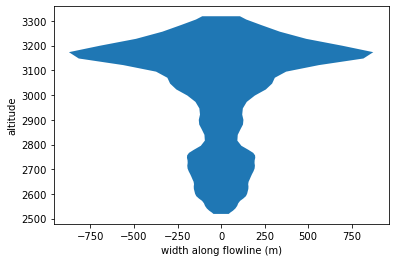

In [6]:
# width change over heights of our simplified glacier:
h,w = gdir.get_inversion_flowline_hw()
plt.fill_betweenx(h, -w/2,w/2)
plt.ylabel('altitude')
plt.xlabel('width along flowline (m)')

### Average steepness of the glacier (according to the model)

In [7]:
rad_flowline_avg_slope = utils.glacier_statistics(gdir)['flowline_avg_slope']  # in radians

rad_flowline_avg_slope

0.3188901912757942

In [8]:
np.rad2deg(rad_flowline_avg_slope) # in degree 

18.271062088222553

## Get specific mass-balance over the years:

get the overall specific mass-balance over the year:
 - if it is negative the glacier lost mass over the entire year
 - if it is positive it has gained mass over that year
 
Can you explain the trend over last years from the climate (look at the plots further below!)

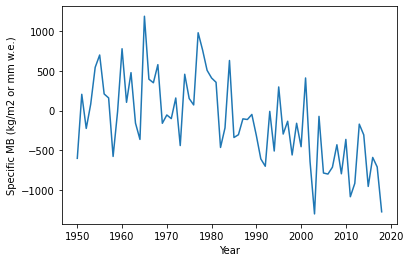

In [9]:
# Get the calibrated mass-balance model - the default is to use OGGM's "PastMassBalanceModel"
mbmod = massbalance.MultipleFlowlineMassBalance(gdir)

# Compute the specific MB for this glacier
fls = gdir.read_pickle('model_flowlines')
years = np.arange(1950, 2019)
mb_ts = mbmod.get_specific_mb(fls=fls, year=years)

plt.plot(years, mb_ts);
plt.ylabel('Specific MB (kg/m2 or mm w.e.)');
plt.xlabel('Year');

Let's look at the mean climate (averaged over the year and averaged over the glacier altitude): 

In [10]:
t_mean = []
solidprcp_mean = []
for y in np.arange(1979, 2020):
    t,_,_,solidprcp = mbmod.flowline_mb_models[-1].get_annual_climate(h, year=y)
    t_mean.append(t.mean())
    solidprcp_mean.append(solidprcp.mean())

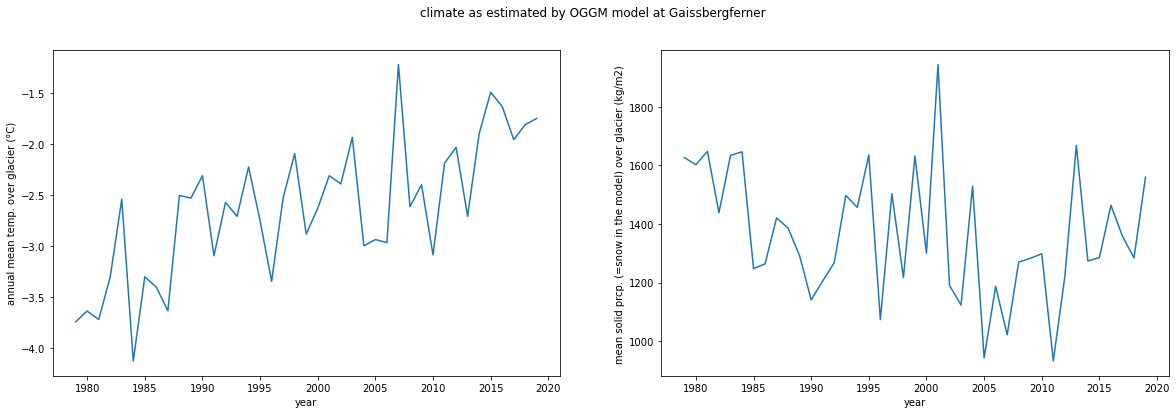

In [11]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(np.arange(1979, 2020), t_mean)
plt.ylabel('annual mean temp. over glacier (°C)')
plt.xlabel('year')    

plt.subplot(122)
plt.plot(np.arange(1979, 2020), solidprcp_mean)
plt.ylabel('mean solid prcp. (=snow in the model) over glacier (kg/m2) ')
plt.xlabel('year')
plt.suptitle('climate as estimated by OGGM model at Gaissbergferner');

# Estimate mass-balance along the glacier profile to get mass-balance gradient and ELA:

In [12]:
heights_l = {}
widths_l = {}
mb_l = {}
ela = {}
for y in np.arange(1979, 2020):
    heights_l[y], widths_l[y], mb_l[y] = mbmod.get_annual_mb_on_flowlines(fls, year=y)
    ela[y] = mbmod.get_ela(year=y) # ELA is just the altitude where MB = 0 

In [13]:
mean_ela = pd.DataFrame(ela, index=['ela']).mean(axis=1).values[0]
mean_mb_prof = pd.DataFrame(mb_l).mean(axis=1)*cfg.SEC_IN_YEAR *cfg.PARAMS['ice_density']
# compute MB gradient
import scipy
mean_mb_gradient, _, _, _, _ = scipy.stats.linregress(pd.DataFrame(heights_l).mean(axis=1), pd.DataFrame(mb_l).mean(axis=1)*cfg.SEC_IN_YEAR *cfg.PARAMS['ice_density'])


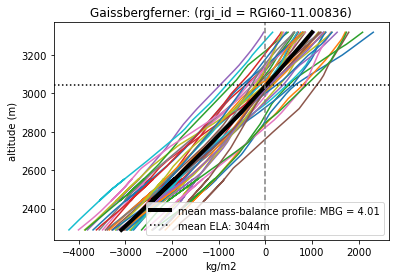

In [14]:
for y in np.arange(1979, 2020):
    plt.plot(mb_l[y]*cfg.SEC_IN_YEAR *cfg.PARAMS['ice_density'], heights_l[y]);
plt.plot(mean_mb_prof, heights_l[y], color = 'black', lw = 4, label= f'mean mass-balance profile: MBG = {mean_mb_gradient:.2f}')
plt.xlabel('kg/m2')
plt.ylabel('altitude (m)')
plt.axvline(0, ls = '--', color = 'grey')
plt.axhline(mean_ela, ls=':', color = 'black', label = f'mean ELA: {mean_ela:.0f}m')
plt.title(f'Gaissbergferner: (rgi_id = {gdir.rgi_id})');
plt.legend();

- each colored line corresponds to the mass-balance profile of the model of one specific year
- here we estimate the mass-balance even for altitudes where the glacier does not exist anymore (see below the approx. altitude range of the glacier)

In [15]:
max_altitude = heights_l[y][widths_l[y]>0].max()
min_altitude = heights_l[y][widths_l[y]>0].min()
print(f'actual glacier range in the model is between maximum {max_altitude:.0f} m and minimum {min_altitude:.0f} m')

actual glacier range in the model is between maximum 3319 m and minimum 2519 m


Let's have a look on the ELA evolution over the time (from model estimates):

Text(0.5, 0, 'year')

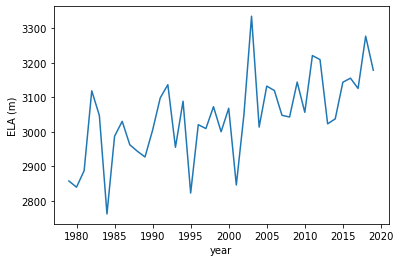

In [31]:
plt.plot(np.arange(1979,2020,1), pd.DataFrame(ela, index=['ela']).loc['ela'].values)
plt.ylabel('ELA (m)')
plt.xlabel('year')

#### Bonus: how gaissbergferner could have evolved from 2003 to 2020 (one possible model estimate out of many)

2022-03-21 12:01:24: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2022-03-21 12:01:24: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2022-03-21 12:01:24: oggm.utils: Applying global task compile_run_output on 1 glaciers
2022-03-21 12:01:24: oggm.utils: Applying compile_run_output on 1 gdirs.


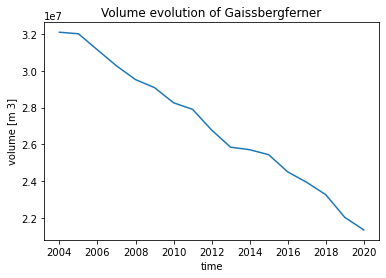

In [16]:
gdirs = workflow.init_glacier_directories(['RGI60-11.00836'], from_prepro_level=5)
ds = utils.compile_run_output(gdirs, input_filesuffix='_historical')
ds.volume.plot(hue='rgi_id');
plt.title('Volume evolution of Gaissbergferner');

#### Bonus 2: how gaissbergferner could have evolved from 2020 to 2100 (one possible model estimate out of many)

In [17]:
from oggm.core import gcm_climate
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                                 filesuffix='_CCSM4_{}'.format(rcp),  # recognize the climate file for later
                                 fpath_temp=ft,  # temperature projections
                                 fpath_precip=fp,  # precip projections
                                 );

/home/lilianschuster/oggm/oggm/core/gcm_climate.py:3: FutureWarning: The module `oggm.core.gcm_climate` has moved to oggm.shop.gcm_climate. This compatibility module will be removed in future OGGM versions
  warnings.warn('The module `oggm.core.gcm_climate` has moved to '
100% of 109.7 MiB |######################| Elapsed Time: 0:00:13 Time:  0:00:13
100% of 109.7 MiB |######################| Elapsed Time: 0:00:08 Time:  0:00:08
2022-03-21 12:01:46: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
100% of 109.7 MiB |######################| Elapsed Time: 0:00:09 Time:  0:00:09
100% of 109.7 MiB |######################| Elapsed Time: 0:00:09 Time:  0:00:09
2022-03-21 12:02:06: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
100% of 109.7 MiB |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% of 109.7 MiB |######################| Elapsed Time: 0:00:09 Time:  0:00:09
2022-03-21 12:02:28: oggm.workflow: Execute entity tasks [process

In [18]:
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    workflow.execute_entity_task(tasks.run_from_climate_data, gdirs, ys=2020, 
                                 climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                 climate_input_filesuffix=rid,  # use the chosen scenario
                                 init_model_filesuffix='_historical',  # this is important! Start from 2020 glacier
                                 output_filesuffix=rid,  # recognize the run for later
                                );

2022-03-21 12:02:57: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2022-03-21 12:02:58: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2022-03-21 12:02:58: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2022-03-21 12:02:58: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers


2022-03-21 12:02:59: oggm.utils: Applying global task compile_run_output on 1 glaciers
2022-03-21 12:02:59: oggm.utils: Applying compile_run_output on 1 gdirs.
2022-03-21 12:02:59: oggm.utils: Applying global task compile_run_output on 1 glaciers
2022-03-21 12:02:59: oggm.utils: Applying compile_run_output on 1 gdirs.
2022-03-21 12:02:59: oggm.utils: Applying global task compile_run_output on 1 glaciers
2022-03-21 12:02:59: oggm.utils: Applying compile_run_output on 1 gdirs.
2022-03-21 12:02:59: oggm.utils: Applying global task compile_run_output on 1 glaciers
2022-03-21 12:02:59: oggm.utils: Applying compile_run_output on 1 gdirs.


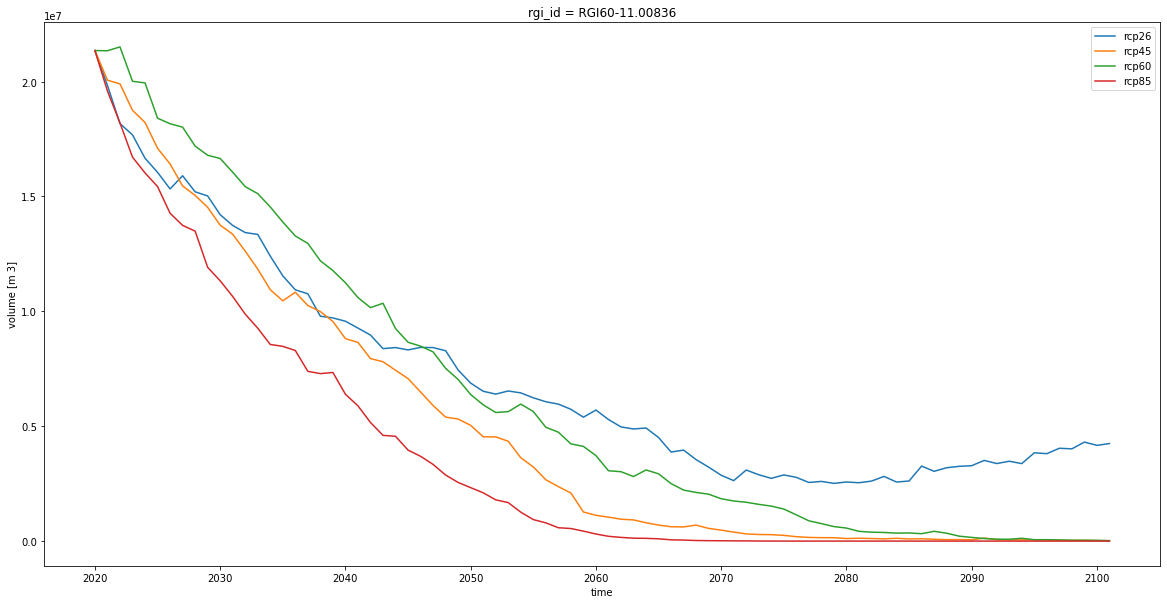

In [19]:
f, (ax1) = plt.subplots(1, 1, figsize=(20, 10))
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
    ds.isel(rgi_id=0).volume.plot(ax=ax1, label=rcp);
    #ds.isel(rgi_id=1).volume.plot(ax=ax2, label=rcp);
plt.legend();

- We use different greenhouse gas emission scenarios to simulate how our glacier will evolve in the future:
    - in short: the larger the number, the more greenhouse gases will be emitted
    - with the rcp85 scenario much more global warming will occur than in the rcp26 scenario, which has dramatic consequences for our Gaissbergferner in our model!
        - In which scenario could our glacier survive? 

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)